# Morse Localnet Testing Notebook

This notebook expects that the localnet and the models are deployed and working correctly. Please refer to the README file in this folder for more details on how to set up.

In [3]:
from matplotlib import pyplot as plt
from copy import deepcopy
import json
import os
import subprocess
import base64
from PIL import Image
from io import BytesIO


In [4]:
POCKET_LOCALNET_PATH = '../pocket-localnet' # Modify this to match your local files

### Relayer wrapper functions

This function is used to interact with the relayer.
We use the relayer provided in `pocket-localnet`, wich is not the best. This is only a proof of concept and the objective of this notebook is not to provide a python wrapper of the pocket network ML-RPCs.

In [5]:
pokt_base_relay = {
  "rpcUrls":  ["http://mesh.dev:9081"],
  "whitelistedServicers": [],
  "appPrivKey": "6d7d9e78fd62b524cfa76a298b6f9653445449bc22960224901a5bb993ba52cb1802f4116b9d3798e2766a2452fbeb4d280fa99e77e61193df146ca4d88b38af",
  "chain": {},
  "mesh": {
    "enabled": True,
    "rpcUrl": "http://mesh.dev:9081"
  },
  "relays": 1,
  "logRelayData": True,
  "logFile": "logs/relays.log",
  "writeRawRelayData": True,
  "rawFile": "logs/relays.raw"
}

def pokt_relay(chain, endpoint, data, method="POST", copies=1):
  # create the pocket data
  this_request = deepcopy(pokt_base_relay)
  this_request['relays'] = copies
  this_request['chain'] = {"id": chain,
                "callSet": [
                      {
                        "method": method,
                        "path": endpoint,
                        "data": json.dumps(data)
                      }
                  ]
              }
  # Save this as the data.json in the relayer directory
  with open(os.path.join(POCKET_LOCALNET_PATH, 'relayer/data.json'), 'w') as f:
    json.dump(this_request, f)

  # Delete raw relays file
  relaysfile = os.path.join(POCKET_LOCALNET_PATH, 'relayer/logs/relays.raw')
  if os.path.exists(relaysfile):
    os.remove(relaysfile)
  # Delete logs
  logfile = os.path.join(POCKET_LOCALNET_PATH, 'relayer/logs/relays.log')
  if os.path.exists(logfile):
    os.remove(logfile)

  # trigger relay
  subprocess.run("yarn start", shell=True, cwd=os.path.join(POCKET_LOCALNET_PATH, 'relayer'))

  # Read responses
  response_list = list()
  with open(relaysfile, 'r') as lf:
      for line in lf.readlines():
         response_list.append(json.loads(line))

  return response_list
          




### Large Language Model

In [7]:
prompt = "What is a memecoin?\n"

# Fill data json for endpoint
llm_data = {
            "model": "pokt_vllm_test", 
            "prompt": prompt, 
            "max_tokens": 2048, 
            "temperature": 0.25
            }
# Do the relay
response_list = pokt_relay('A100', "/v1/completions", llm_data)

yarn run v1.22.19
$ node -r dotenv/config index.js
[2024-03-14T14:04:47.594Z]  INFO: relayer/11603 on Ramiros-MacBook-Pro.local: reading ./data.json file
[2024-03-14T14:04:50.264Z]  INFO: relayer/11603 on Ramiros-MacBook-Pro.local: analyzing results { relays: 1 }
[2024-03-14T14:04:50.265Z] DEBUG: relayer/11603 on Ramiros-MacBook-Pro.local:
  relay data {
    hash: '66e7088fc72b5c701ecfe4ed3cdfd34e74d961ddba5d8645b235a6054b23824a',
    request: {
      method: 'POST',
      path: '/v1/completions',
      data: '{"model": "pokt_vllm_test", "prompt": "What is a memecoin?\\n", "max_tokens": 2048, "temperature": 0.25}'
    },
    response: '{"id":"cmpl-5e332a1a8ff84b21bce58afd5d46bc9e","object":"text_completion","created":40861,"model":"pokt_vllm_test","choices":[{"index":0,"text":"\\nA memecoin is a type of cryptocurrency that is created and promoted primarily to capitalize on a popular internet meme or cultural phenomenon. These coins often have no practical use or value beyond their asso

In [8]:
# Get text response
generation = response_list[0]['choices'][0]['text']
# Print
print("---"*100)
print("Prompt:\n%s"%prompt)
print("---"*100)
print("Generation:\n%s"%generation)
print("---"*100)


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prompt:
What is a memecoin?

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Generation:

A memecoin is a type of cryptocurrency that is created and promoted primarily to capitalize on a popular internet meme or cultural phenomenon. These coins often have no practical use or value beyond their association with the meme, and are typically created as a joke or as a form of satire.

Some of the most well-known memecoins include Dogecoin, which w

### Diffusion Model

In [61]:
# Text to Image

prompt = "a plain big jacket in the frontground"
negative_prompt = "pockets zippers hands pouch"

# Fill data json for endpoint
diffuser_data = {
                "prompt" : [prompt],
                "negative_prompt" : [negative_prompt],
                "height" : 512,
                "width" : 512,
                "num_inference_steps" : 25,
                "guidance_scale":  7.0,
                "output_type" : "JPEG",
                "sag_scale" : 1.0 
            }
# Do the relay
response_list = pokt_relay('A1D0', "/text2img", diffuser_data)

yarn run v1.22.19
$ node -r dotenv/config index.js
[2024-03-14T14:53:12.355Z]  INFO: relayer/37926 on Ramiros-MacBook-Pro.local: reading ./data.json file
[2024-03-14T14:53:14.774Z]  INFO: relayer/37926 on Ramiros-MacBook-Pro.local: analyzing results { relays: 1 }
[2024-03-14T14:53:14.775Z] DEBUG: relayer/37926 on Ramiros-MacBook-Pro.local:
  relay data {
    hash: '904c85c0a7aba4fc37f7d47e12555d3469645069bf436b6b906eb067eef268d7',
    request: {
      method: 'POST',
      path: '/text2img',
      data: '{"prompt": ["a plain big jacket in the frontground"], "negative_prompt": ["pockets zippers hands pouch"], "height": 512, "width": 512, "num_inference_steps": 25, "guidance_scale": 7.0, "output_type": "JPEG", "sag_scale": 1.0}'
    },
    response: '{"status":"success","generationTime":1.8295512199401855,"id":0,"output":["/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjI

In [ ]:
decoded_data = base64.b64decode(response_list[0]['output'][0])
output_image = Image.open(BytesIO(decoded_data))

In [63]:
# Image+Text to Image

prompt = "Lots of pockets in the jacket"
negative_prompt = ""

# Fill data json for endpoint
diffuser_data = {
                "prompt" : [prompt],
                "negative_prompt" : [negative_prompt],
                'base_img_data' : {
                    'img_data' : [],
                    'img_data_format': 'raw_bytes',
                    'img_type': 'RGB',
                    'img_height': 512,
                    'img_width': 512,
                },
                'height' : 512,
                'width' : 512,
                'num_inference_steps' : 50,
                'guidance_scale':  25.0,
                "output_type" : "JPEG",
            }
# Encode image data to send it to the API
diffuser_data['base_img_data']['img_data'].append(base64.b64encode(output_image.tobytes()).decode("utf-8"))
# Do the relay
response_list = pokt_relay('A1D0', "/img2img", diffuser_data)

yarn run v1.22.19
$ node -r dotenv/config index.js
[2024-03-14T14:53:17.809Z]  INFO: relayer/37966 on Ramiros-MacBook-Pro.local: reading ./data.json file
[2024-03-14T14:53:20.155Z]  INFO: relayer/37966 on Ramiros-MacBook-Pro.local: analyzing results { relays: 1 }
[2024-03-14T14:53:20.156Z] DEBUG: relayer/37966 on Ramiros-MacBook-Pro.local:
  relay data {
    hash: '9ea365f96f8f61887f2ff46dc12aa81f498289915ee8c384371dc73670ffcd9e',
    request: {
      method: 'POST',
      path: '/img2img',
      data: '{"prompt": ["Lots of pockets in the jacket"], "negative_prompt": [""], "base_img_data": {"img_data": ["iIeFiIeFiIeFiIeFiIeFiIeFiIeFiIeFiYiGiYiGiYiGiYiGiYiGiYiGiYiGiYiGiomHiomHiomHiomHiomHiomHiomHiomHiomHiomHiomHi4qIi4qIjIuJjIuJjIuJjIuJjIuJjIuJjYyKjYyKjo2Ljo2Ljo2Lj46Mj46Mj46Mj46Mj46Mj46Mj46Mj46Mj46Mj46Mj46Mj46Mj46Mj46Mj46Mj46MkI+NkI+NkI+NkZCOkZCOkpGPkpGPkpGPkpGPkpGPkpGPk5KQk5KQlJORlJORlJORlJORlJORlJORlZSSlZSSlpWTlpWTlpWTlpWTlpWTlpWTlpWTlpWTlpWTlpWTlpWTl5aUl5aUl5aUl5aUl5aUl5aUl5aUl5aUl5aU

In [ ]:
decoded_data = base64.b64decode(response_list[0]['output'][0])
refined_output_image = Image.open(BytesIO(decoded_data))

In [77]:
# Inpainting

prompt = "a big green candle"
negative_prompt = "red white"

# Fill data json for endpoint
diffuser_data = {
                "prompt" : [prompt],
                "negative_prompt" : [negative_prompt],
                'base_img_data' : {
                    'img_data' : [],
                    'img_data_format': 'raw_bytes',
                    'img_type': 'RGB',
                    'img_height': 512,
                    'img_width': 512,
                },
                'mask_img_data' : {
                    'img_data' : [],
                    'img_data_format': 'raw_bytes',
                    'img_type': 'RGB',
                    'img_height': 512,
                    'img_width': 512,
                },
                'height' : 512,
                'width' : 512,
                'num_inference_steps' : 50,
                'guidance_scale':  15,
                'strength':  0.99,
                'aesthetic_score': 6,
                'negative_aesthetic_score': 2.5,
                "output_type" : "JPEG",
            }
# Encode image data to send it to the API
diffuser_data['base_img_data']['img_data'].append(base64.b64encode(refined_output_image.tobytes()).decode("utf-8"))

# Read mask image
mask_image = Image.open('./mask_test.png').resize(refined_output_image.size)
diffuser_data['mask_img_data']['img_data'].append(base64.b64encode(mask_image.tobytes()).decode("utf-8"))

# Do the relay
response_list = pokt_relay('A1D0', "/inpainting", diffuser_data)

yarn run v1.22.19
$ node -r dotenv/config index.js
[2024-03-14T14:55:27.217Z]  INFO: relayer/38986 on Ramiros-MacBook-Pro.local: reading ./data.json file
[2024-03-14T14:55:32.210Z]  INFO: relayer/38986 on Ramiros-MacBook-Pro.local: analyzing results { relays: 1 }
[2024-03-14T14:55:32.211Z] DEBUG: relayer/38986 on Ramiros-MacBook-Pro.local:
  relay data {
    hash: '90a16b19447243c4bd60e85a4d69c606726e061be8641a64675e1b2d5e37e61b',
    request: {
      method: 'POST',
      path: '/inpainting',
      data: '{"prompt": ["a big green candle"], "negative_prompt": ["red white"], "base_img_data": {"img_data": ["h4aCh4aCh4aCiIeDiIeDiYiEiYiEiYiEiYiEiYiEiYiEiYiEiYiEiYiEiYiEiYiEiYiGiYiGiIeFiYiGiomHi4qIjIuJjYyKjYyKjYyKjYyKjYyKjYyKjYyKjYyKjYyKjYyKjYyKjYyKjYyKjYyKjYyKjYyKjYyKjo2Ljo2Ljo2Ljo2Ljo2Ljo2Ljo2Ljo2Lj4+Pjo6OjIyMi4uLjIyMjo6OkJCQkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZCOkZCOkZCOkpGPkpGPk5KQk5KQk5KQk5KQlJORlZSSlpWTl5aUmJeVl5aUl5aUl5WWl5WWl5WWl5WWl5WWl5WWl5WWl5WWmJaXmJaXmJaXmJaXmJaXmJaXmJaXmJaXmZi

In [ ]:
decoded_data = base64.b64decode(response_list[0]['output'][0])
inpaint_output_image = Image.open(BytesIO(decoded_data))

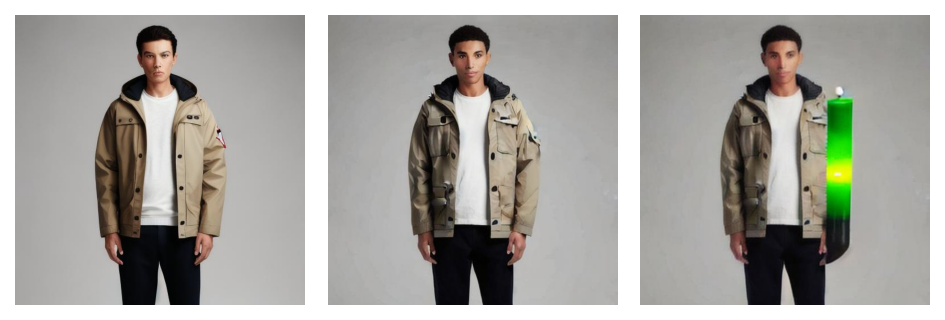

In [82]:
# Final result

plt.figure(dpi=150)
plt.subplot(1,3,1)
plt.imshow(output_image)
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(refined_output_image)
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(inpaint_output_image)
plt.axis("off")
plt.tight_layout()
plt.show()